## Technical Test: Exploratory Data Analysis
### 1 - Imports and environment setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import category_encoders as ce

# Plotting configuration
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (14, 7)
warnings.filterwarnings('ignore')

### 2 - Data loading

In [2]:
# Load dataset
try:
    df = pd.read_csv('../data/dataset.csv')
    print(f"Dataset loaded successfully: {df.shape[0]} rows and {df.shape[1]} columns.")
except FileNotFoundError:
    print("Error: Data file not found. Please check the path.")

df.head()

Dataset loaded successfully: 7420 rows and 16 columns.


,DocumentRatingSource,FlownYear,FlownMonth,AgentCode,AgentName,POS,POSCountryName,OriginCode,DestinationCode,CargoType,ProductCode,SpecialHandlingCodeList,CommodityCode,ChargeableWeight,Pieces,Revenue
0,XXXX,2017,NOVEMBER,SPRTQLS,SPRT4FP23CI1H34U12IFDORKMSBKLSW,QQJ,FBDFZRQ7ONHZOUWG0XX3VAORZJQEAYOPBCLJ,FTS,ZZZ,YYY,X,RWCBA,RC,21.0,1,15.05
1,XXXX,2017,SEPTEMBER,SPRTQLS,SPRT4FP23CI1H34U12IFDORKMSBKLSW,QQJ,FBDFZRQ7ONHZOUWG0XX3VAORZJQEAYOPBCLJ,FTS,ZZZ,YYY,X,RWCBA,ZW,13.2,1,9.46
2,XXXX,2017,SEPTEMBER,PJMIGRN,PJMIGWSX3CI1SROQTOOFWTJYDDMKEH,JLL,LVSSPJMDKYSQRCHI,JLL,ZZZ,YYY,X,RWCBA,ZW,15.6,1,9.16
3,XXXX,2017,OCTOBER,SPRTQLS,SPRT4FP23CI1H34U12IFDORKMSBKLSW,QQJ,FBDFZRQ7ONHZOUWG0XX3VAORZJQEAYOPBCLJ,FTS,ZZZ,YYY,X,RWCBA,ZW,3.0,1,2.15
4,XXXX,2017,SEPTEMBER,PBKDDPW,PBKDWYFR3DRTS3ZLNHTSGTJYDDMKEH,JUW,JJDIVESWZJQEAYOPBCLJ,JUW,ZZZ,YYY,X,RWCBA,BW,12.0,1,17.08


In [3]:
# Data quality report
quality_report = pd.DataFrame({
    'Data_Type': df.dtypes,
    'Missing_Values': df.isnull().sum(),
    'Percent_Missing': (df.isnull().sum() / len(df) * 100).round(2),
    'Unique_Values': df.nunique()
})

print("Data Quality Report:")
print(quality_report)
print(f"\nNumber of duplicate rows: {df.duplicated().sum()}")

Data Quality Report:
                        Data_Type  Missing_Values  Percent_Missing  \
DocumentRatingSource       object               0              0.0   
FlownYear                   int64               0              0.0   
FlownMonth                 object               0              0.0   
AgentCode                  object               0              0.0   
AgentName                  object               0              0.0   
POS                        object               0              0.0   
POSCountryName             object               0              0.0   
OriginCode                 object               0              0.0   
DestinationCode            object               0              0.0   
CargoType                  object               0              0.0   
ProductCode                object               0              0.0   
SpecialHandlingCodeList    object               0              0.0   
CommodityCode              object               0              0.0   

Key bservations:
- Constants: FlownYear and DestinationCode can be ignored since they only contain one unique value
- Duplicates: The report shows 783 duplicate rows
- Cardinality: AgentCode (679) and SpecialHandlingCodeList (552) are high-cardinality categorical features

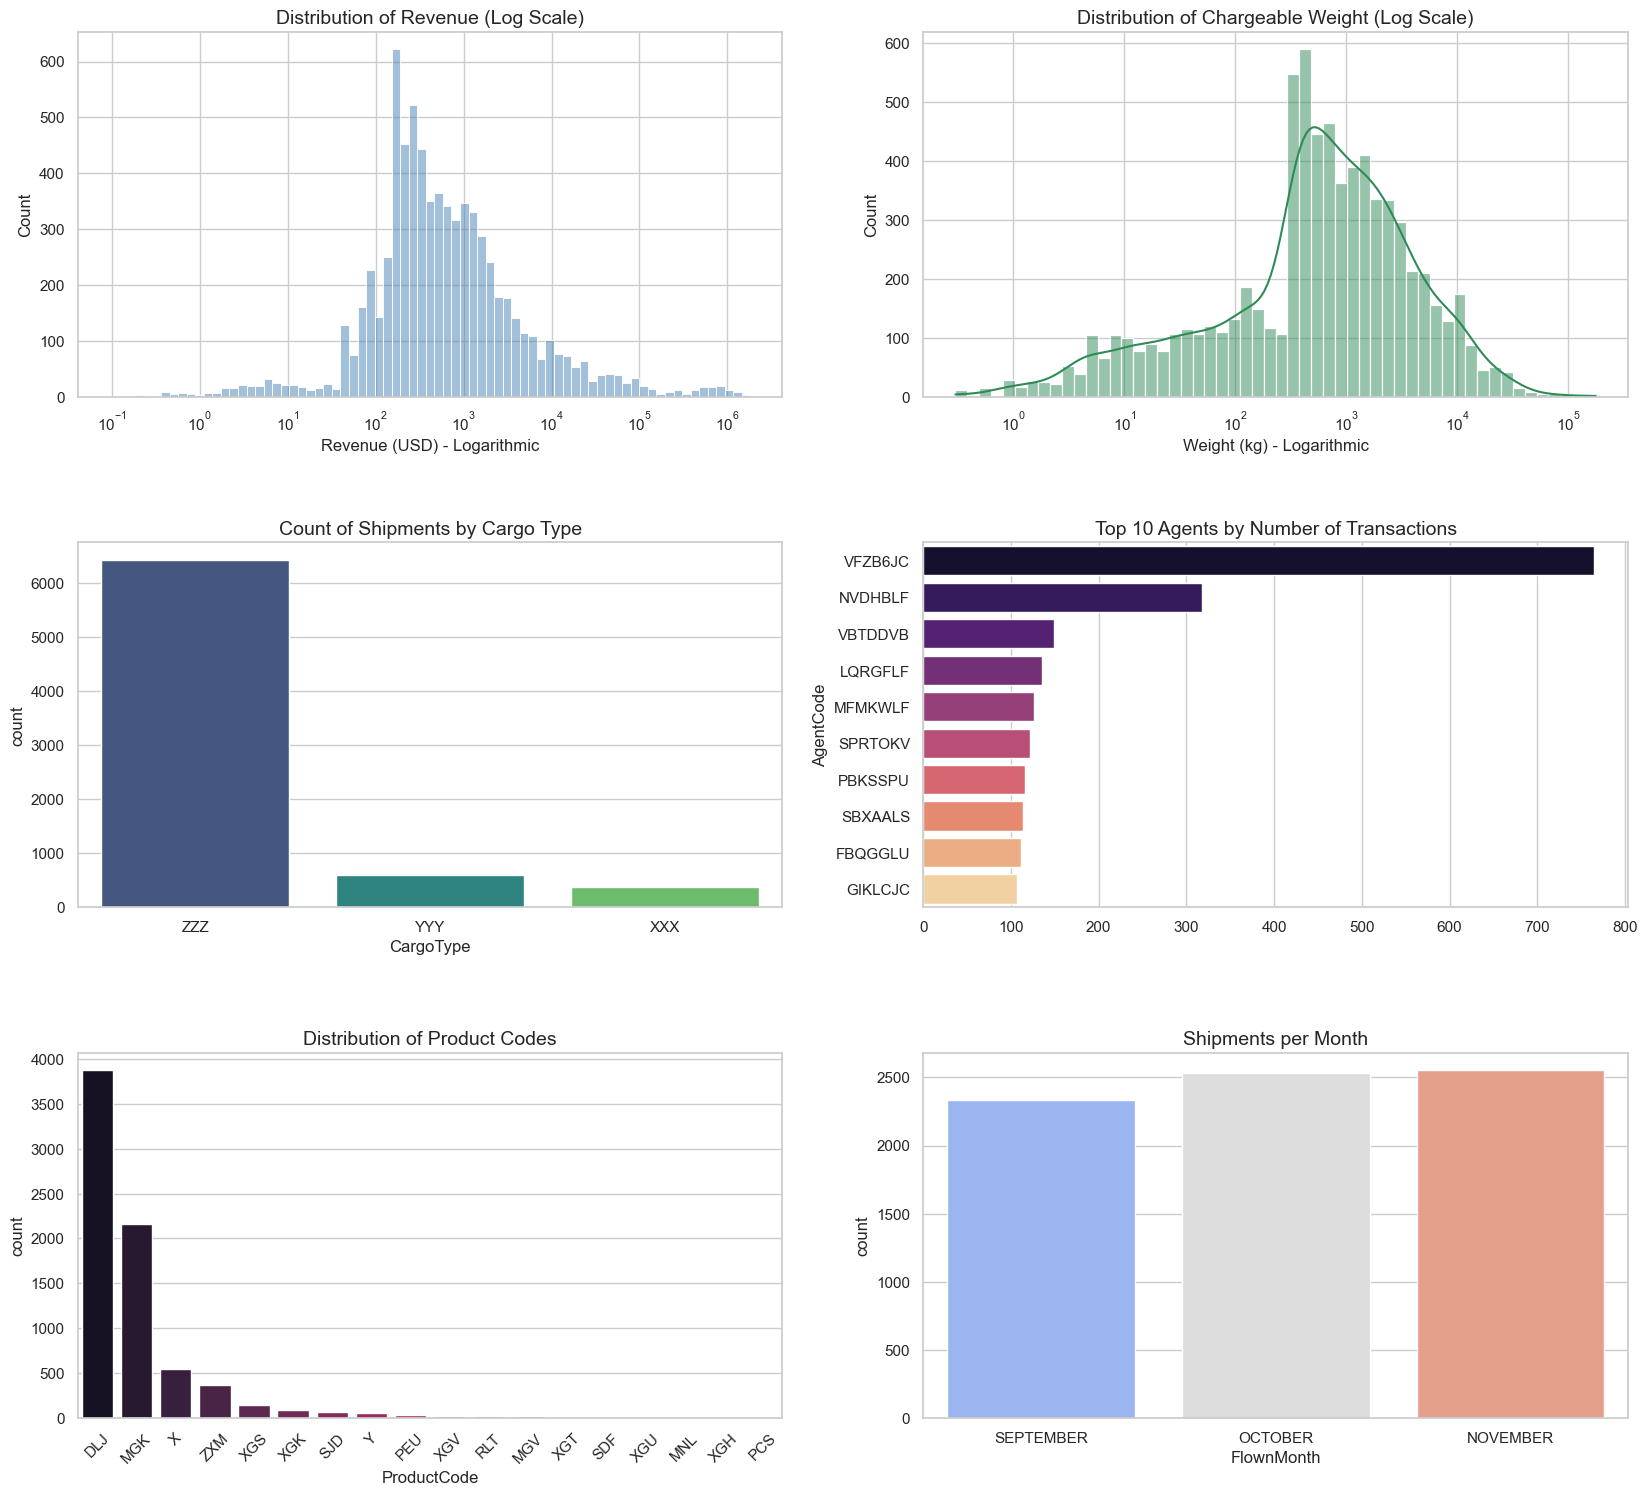

In [4]:
# Create a figure with a grid of subplots
fig, axes = plt.subplots(3, 2, figsize=(20, 18))
plt.subplots_adjust(hspace=0.4)

# 1. Distribution of the Target Variable (Revenue)
sns.histplot(df['Revenue'], kde=True, ax=axes[0, 0], color='steelblue', log_scale=True)
axes[0, 0].set_title('Distribution of Revenue (Log Scale)', fontsize=14)
axes[0, 0].set_xlabel('Revenue (USD) - Logarithmic')

# 2. Distribution of ChargeableWeight
sns.histplot(df['ChargeableWeight'], kde=True, ax=axes[0, 1], color='seagreen', log_scale=True)
axes[0, 1].set_title('Distribution of Chargeable Weight (Log Scale)', fontsize=14)
axes[0, 1].set_xlabel('Weight (kg) - Logarithmic')

# 3. Categorical: CargoType (Low Cardinality)
sns.countplot(data=df, x='CargoType', ax=axes[1, 0], palette='viridis', order=df['CargoType'].value_counts().index)
axes[1, 0].set_title('Count of Shipments by Cargo Type', fontsize=14)

# 4. Categorical: Top 10 Agents (High Cardinality)
top_agents = df['AgentCode'].value_counts().iloc[:10]
sns.barplot(x=top_agents.values, y=top_agents.index, ax=axes[1, 1], palette='magma')
axes[1, 1].set_title('Top 10 Agents by Number of Transactions', fontsize=14)

# 5. Categorical: ProductCode
sns.countplot(data=df, x='ProductCode', ax=axes[2, 0], palette='rocket', order=df['ProductCode'].value_counts().index)
axes[2, 0].set_title('Distribution of Product Codes', fontsize=14)
axes[2, 0].tick_params(axis='x', rotation=45)

# 6. Categorical: FlownMonth
df['FlownMonth'] = df['FlownMonth'].str.strip().str.upper()
month_order = ['SEPTEMBER', 'OCTOBER', 'NOVEMBER']
existing_months = [m for m in month_order if m in df['FlownMonth'].unique()]
sns.countplot(data=df, x='FlownMonth', ax=axes[2, 1], palette='coolwarm', order=existing_months)
axes[2, 1].set_title('Shipments per Month', fontsize=14)

plt.show()

### 3 - Data transformation
#### a) Handling duplicates
Removing the duplicates should prevent the model from over-fitting to repeated noise.

In [5]:
initial_rows = len(df)
df = df.drop_duplicates().reset_index(drop=True)
print(f"Dropped {initial_rows - len(df)} duplicate rows.")

Dropped 783 duplicate rows.


#### b) Feature engineering
We can create some relevant columns from the data we have :
- Route feature: Pricing is heavily dependent on the lane but here we only have one destination code so it is not relevant
- Shipment Density: Heavy small boxes vs light large boxes
- Log Transformations: Since data has extreme values, models will perform much better if we predict the Log of Revenue
- Extract Month as a periodic feature: we can even use Sine/Cosine transform if we want the model to know Dec is near Jan
- Yield: defining the target as Yield (Price per Kg) as requested

In [6]:
# 1. Shipment Density:
df['WeightPerPiece'] = df['ChargeableWeight'] / (df['Pieces'] + 1e-5)

# 2. Log Transformations: 
df['Log_Revenue'] = np.log1p(df['Revenue'])
df['Log_Weight'] = np.log1p(df['ChargeableWeight'])

# 3. Extract Month as a periodic feature
month_map = {'SEPTEMBER': 9, 'OCTOBER': 10, 'NOVEMBER': 11, 'DECEMBER': 12}
df['Month_Num'] = df['FlownMonth'].map(month_map)

# 4. Yield (Price per kg)
df['Yield'] = df['Revenue'] / (df['ChargeableWeight'] + 1e-5)

print("Feature engineering complete.")

Feature engineering complete.


#### c) Drop columns
Based on the unique value counts and field definitions, we should drop columns that provide zero variance or carry redundant information:
- FlownYear & DestinationCode: These have only 1 unique value
- AgentName: We already have AgentCode. Keeping both is redundant
- POSCountryName: POS (Point of Sale city) is more granular

In [7]:
# Dropping useless columns
cols_to_drop = ['FlownYear', 'DestinationCode', 'AgentName', 'POSCountryName']
df_model = df.drop(columns=cols_to_drop)

#### d) Handling high cardinality
For fields like AgentCode, OriginCode, and SpecialHandlingCodeList, we cannot use One-Hot Encoding (it would create ~1,500 columns). We know 3 possible solutions:
- Target Encoding: replace each category with the average Revenue for that category
- Frequency Encoding: replace the code with its count or percentage in the dataset
- Binary Encoding : converts the category into binary code (0/1) across several columns

We will choose Target Encoding here because tt creates a direct correlation between the Agent/Origin and the target variable. For the SpecialHandlingCodeList we could have proceeded in another way if the columns were explicit (example : perishable..).

In [8]:
# 1. High cardinality columns
high_card_cols = [
    'AgentCode', 
    'OriginCode', 
    'POS', 
    'SpecialHandlingCodeList', 
    'CommodityCode',
    'ProductCode'
]

# 2. Apply Target Encoding
# We use 'Log_Revenue' as the target to minimize the impact of outliers.
# M-probability smoothing is used to handle categories with very few samples.
target_encoder = ce.TargetEncoder(cols=high_card_cols, smoothing=10)

# Fit and transform
df_model[high_card_cols] = target_encoder.fit_transform(
    df_model[high_card_cols], 
    df['Log_Revenue']
)

# 3. One-hot encoding for low cardinality column CargoType
df_model = pd.get_dummies(df_model, columns=['CargoType'], drop_first=True)

# 4. Final cleanup
# Drop columns that were used for engineering but aren't features (like the raw Month string)
# Keep only numerical features for the model.
df_model = df_model.select_dtypes(include=[np.number])

print(f"Feature set updated. New shape: {df_model.shape}")
display(df_model.head())

Feature set updated. New shape: (6637, 14)


,AgentCode,POS,OriginCode,ProductCode,SpecialHandlingCodeList,CommodityCode,ChargeableWeight,Pieces,Revenue,WeightPerPiece,Log_Revenue,Log_Weight,Month_Num,Yield
0,2.159089,3.416089,3.416089,4.181685,5.708907,6.055675,21.0,1,15.05,20.999790,2.775709,3.091042,11,0.716666
1,2.159089,3.416089,3.416089,4.181685,5.708907,2.622353,13.2,1,9.46,13.199868,2.347558,2.653242,9,0.716666
2,3.580300,3.283979,3.283979,4.181685,5.708907,2.622353,15.6,1,9.16,15.599844,2.318458,2.809403,9,0.587179
3,2.159089,3.416089,3.416089,4.181685,5.708907,2.622353,3.0,1,2.15,2.999970,1.147402,1.386294,10,0.716664
4,2.056728,3.184032,3.184032,4.181685,5.708907,6.223826,12.0,1,17.08,11.999880,2.894806,2.564949,9,1.423332


### 4 - Correlation Matrix Analysis

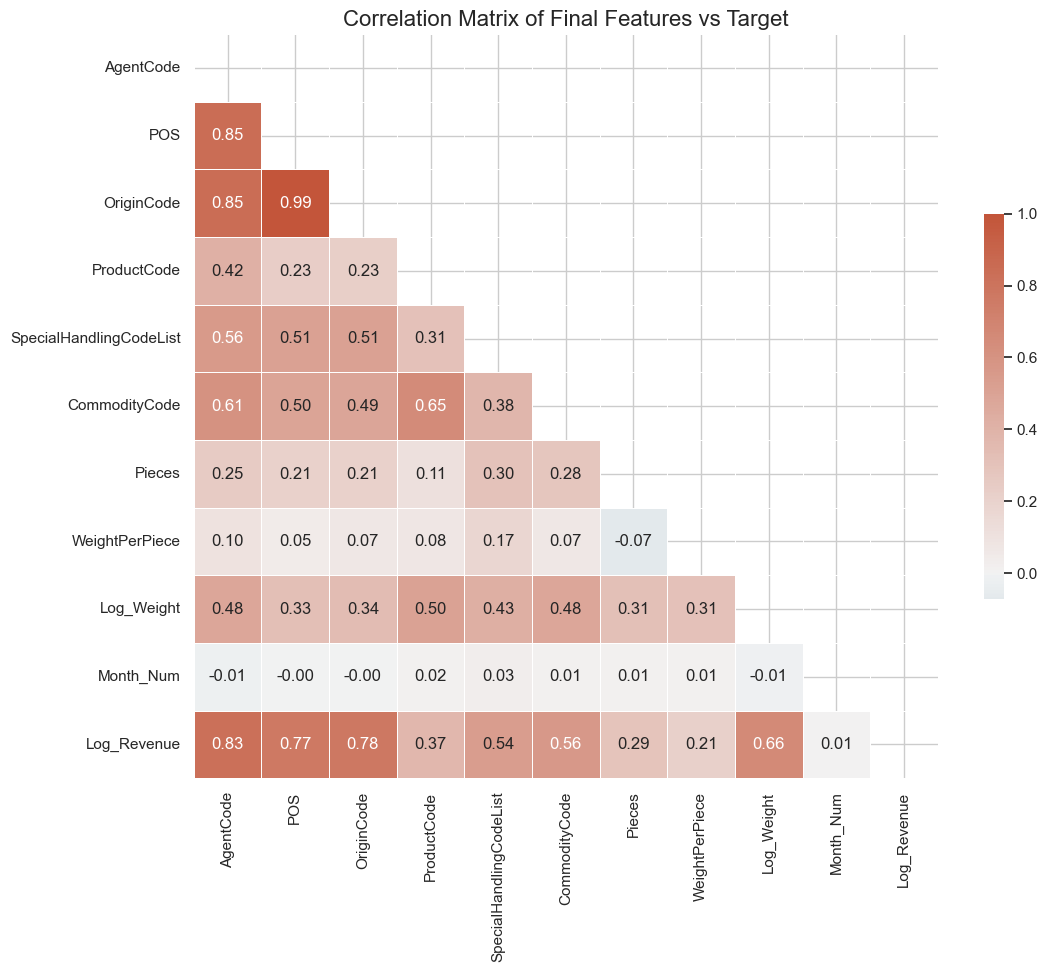

In [9]:
# Select the columns for the correlation matrix
# We include Log_Revenue to see how well our features correlate with the target
correlation_cols = [
    'AgentCode', 'POS', 'OriginCode', 'ProductCode', 
    'SpecialHandlingCodeList', 'CommodityCode', 'Pieces', 
    'WeightPerPiece', 'Log_Weight', 'Month_Num', 'Log_Revenue'
]
corr_matrix = df_model[correlation_cols].corr()

# Create a mask to hide the upper triangle for better readability
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Set up the matplotlib figure
plt.figure(figsize=(12, 10))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap
sns.heatmap(
    corr_matrix, 
    mask=mask, 
    cmap=cmap, 
    vmax=1.0, 
    center=0,
    annot=True, 
    fmt=".2f",
    square=True, 
    linewidths=.5, 
    cbar_kws={"shrink": .5}
)

plt.title('Correlation Matrix of Final Features vs Target', fontsize=16)
plt.show()

### 5 - Saving the dataset

In [10]:
# Save the final processed dataframe to a CSV file
df_model.to_csv('../data/processed_cargo_data.csv', index=False)

print("Dataset successfully saved as processed_cargo_data.csv")

Dataset successfully saved as processed_cargo_data.csv
